In [1]:
import re
import pickle
import string
import copy
from datetime import datetime
from pathlib import Path

import gzip
import json

import jsonpath_ng as jq
import jsonpath_ng.ext as jqe

import neattext as nt
import pandas as pd
import numpy as np
import spacy
import feedparser
import requests
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

import jupyter_black

jupyter_black.load()
data_path = Path("../data")

notebook_start_time = datetime.now()

# get alerts beautifulsoup

In [2]:
url = "https://www.cisa.gov/uscert/ncas/alerts"
page = requests.get(url)
soup = BeautifulSoup(page.text, "html.parser")

In [3]:
soup.title

<title>Alerts | CISA</title>

In [4]:
alert_url = "https://www.cisa.gov/uscert/ncas/alerts/aa22-321a"
alert_page = requests.get(alert_url)
alert_soup = BeautifulSoup(alert_page.text, "html.parser")
soup.title

<title>Alerts | CISA</title>

In [5]:
%%time
# get content for each alert on the first 10 pages of alerts
alerts_new = []

# Load the pre-retrieved data if it's available
soup_alerts_path = Path("soup_alerts.pkl")
if soup_alerts_path.exists():
    with open(soup_alerts_path, "rb") as sap:
        alerts = pickle.load(sap)
else:
    for p_num in range(
        10
    ):  # look at 10 pages of results which should be all the available alerts
        # get the the content from this page
        url = "https://www.cisa.gov/uscert/ncas/alerts?page=" + str(p_num)
        page = requests.get(url)
        soup = BeautifulSoup(page.text, "html.parser")
        table = soup.find_all(class_="views-field views-field-title")

        for i in range(len(table)):
            # get the alert details from this line in the list
            link = table[i].find("a")["href"]
            alert_id = table[i].find(class_="field-content").contents[0]
            title = table[i].find("a").text

            # get alert content
            alert_url = "https://www.cisa.gov/uscert" + link
            alert_page = requests.get(alert_url)
            alert_soup = BeautifulSoup(alert_page.text, "html.parser")
            alert_date = (
                alert_soup.find(id="ncas-header")
                .find(class_="submitted meta-text")
                .text
            )
            alert_text = alert_soup.find(id="ncas-content").text

            # write the content
            alerts_new.append([link, alert_id, title, alert_date, alert_text])

    with open(soup_alerts_path, "wb") as sap:
        pickle.dump(alerts_new, sap)
    alerts = alerts_new
alerts[0]

CPU times: user 93.7 ms, sys: 13.5 ms, total: 107 ms
Wall time: 107 ms


['/ncas/alerts/aa22-321a',
 'AA22-321A : ',
 '#StopRansomware: Hive Ransomware',
 '\n                                Original release date: November 17, 2022  | Last revised: November 25, 2022\n                                            ',
 '\n\nSummary\nActions to Take Today to Mitigate Cyber Threats from Ransomware:\n• Prioritize remediating known exploited vulnerabilities.\n• Enable and enforce multifactor authentication with strong passwords\n• Close unused ports and remove any application not deemed necessary for day-to-day operations.\nNote: This joint Cybersecurity Advisory (CSA) is part of an ongoing #StopRansomware effort to publish advisories for network defenders that detail various ransomware variants and ransomware threat actors. These #StopRansomware advisories include recently and historically observed tactics, techniques, and procedures (TTPs) and indicators of compromise (IOCs) to help organizations protect against ransomware. Visit stopransomware.gov to see all #Stop

In [6]:
%%time
headers = ["link", "alert_id", "title", "date", "text"]
df = pd.DataFrame(alerts, columns=headers)
df.head()

CPU times: user 811 µs, sys: 219 µs, total: 1.03 ms
Wall time: 1.02 ms


,link,alert_id,title,date,text
0,/ncas/alerts/aa22-321a,AA22-321A :,#StopRansomware: Hive Ransomware,\n Original rel...,\n\nSummary\nActions to Take Today to Mitigate...
1,/ncas/alerts/aa22-320a,AA22-320A :,Iranian Government-Sponsored APT Actors Compro...,\n Original rel...,\n\nSummary\nFrom mid-June through mid-July 20...
2,/ncas/alerts/aa22-294a,AA22-294A :,#StopRansomware: Daixin Team,\n Original rel...,\n\nSummary\nActions to take today to mitigate...
3,/ncas/alerts/aa22-279a,AA22-279A :,Top CVEs Actively Exploited By People’s Republ...,\n ...,\n\nSummary\nThis joint Cybersecurity Advisory...
4,/ncas/alerts/aa22-277a,AA22-277A :,Impacket and Exfiltration Tool Used to Steal S...,\n Original rel...,\n\nSummary\nActions to Help Protect Against A...


# parse alert content

In [7]:
re_cve = re.compile(r"(CVE-\d{4}-\d+)")
re_cve.findall(alerts[0][4])

['CVE-2020-12812',
 'CVE-2021-31207',
 'CVE-2021-34473',
 'CVE-2021-34523',
 'CVE-2021-34473',
 'CVE-2021-34523',
 'CVE-2021-31207',
 'CVE-2021-42321']

In [8]:
re_ttp = re.compile(r"(\[|\s)(T\d{4})\.?\d*(\]|\s)")
[ttp[1] for ttp in re_ttp.findall(alerts[1][4])]

['T1190',
 'T1059',
 'T1562',
 'T1105',
 'T1070',
 'T1136',
 'T1016',
 'T1053',
 'T1021',
 'T1078',
 'T1136',
 'T1090',
 'T1018',
 'T1098',
 'T1003',
 'T1190',
 'T1059',
 'T1098',
 'T1136',
 'T1136',
 'T1053',
 'T1078',
 'T1562',
 'T1070',
 'T1003',
 'T1555',
 'T1018',
 'T1016',
 'T1021',
 'T1090',
 'T1105']

In [9]:
%%time
# regex for cve match
re_cve = re.compile(r"(CVE-\d{4}-\d*)")
cves = []
for i in range(len(alerts)):
    alert_cves = sorted(re_cve.findall(alerts[i][4]))
    cves.append(alert_cves)
cves = [set(cve) for cve in cves]

ttps = []
for i in range(len(alerts)):
    alert_ttps = [ttp[1] for ttp in re_ttp.findall(alerts[i][4])]
    alert_ttps = sorted(alert_ttps)
    ttps.append(alert_ttps)
ttps = [set(ttp) for ttp in ttps]

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 43.7 ms


In [10]:
# add list of CVE & TTP to df
df["CVE_list"] = cves
df["TTP_list"] = ttps
# print(df.describe())
df.head()

,link,alert_id,title,date,text,CVE_list,TTP_list
0,/ncas/alerts/aa22-321a,AA22-321A :,#StopRansomware: Hive Ransomware,\n Original rel...,\n\nSummary\nActions to Take Today to Mitigate...,"{CVE-2020-12812, CVE-2021-34523, CVE-2021-3447...","{T1112, T1070, T1562, T1486, T1537, T1490, T15..."
1,/ncas/alerts/aa22-320a,AA22-320A :,Iranian Government-Sponsored APT Actors Compro...,\n Original rel...,\n\nSummary\nFrom mid-June through mid-July 20...,{CVE-2021-44228},"{T1070, T1136, T1555, T1562, T1105, T1021, T10..."
2,/ncas/alerts/aa22-294a,AA22-294A :,#StopRansomware: Daixin Team,\n Original rel...,\n\nSummary\nActions to take today to mitigate...,{},"{T1486, T1563, T1598, T1098, T1003, T1190, T10..."
3,/ncas/alerts/aa22-279a,AA22-279A :,Top CVEs Actively Exploited By People’s Republ...,\n ...,\n\nSummary\nThis joint Cybersecurity Advisory...,"{CVE-2021-26412, CVE-2021-36260, CVE-2021-4223...",{}
4,/ncas/alerts/aa22-277a,AA22-277A :,Impacket and Exfiltration Tool Used to Steal S...,\n Original rel...,\n\nSummary\nActions to Help Protect Against A...,"{CVE-2021-26858, CVE-2021-26855, CVE-2021-2706...","{T1095, T1562, T1029, T1574, T1078, T1049, T10..."


# alert to CVE edges

# alert nodes

In [11]:
from pandas.api.types import is_datetime64_any_dtype

# Clean alert id
df["alert_id"] = df["alert_id"].str.replace(" :", "").str.strip()

# Extract date from date field
if not is_datetime64_any_dtype(df["date"]):
    df["date"] = pd.to_datetime(
        df["date"]
        .str.replace("Original release date: ", "", regex=False)
        .str.replace("\|.*", "", regex=True)
        .str.strip()
    )

# convert link to full path
df["full_path"] = "https://www.cisa.gov" + df["link"]

In [12]:
alerts_nodes = (
    df[["alert_id", "full_path", "title", "date"]]
    .drop_duplicates()
    .reset_index(drop=True)
)
alerts_nodes.to_csv(data_path / "alert_nodes.csv", index=False)
alerts_nodes.to_feather(data_path / "alert_nodes.feather")
alerts_nodes

,alert_id,full_path,title,date
0,AA22-321A,https://www.cisa.gov/ncas/alerts/aa22-321a,#StopRansomware: Hive Ransomware,2022-11-17
1,AA22-320A,https://www.cisa.gov/ncas/alerts/aa22-320a,Iranian Government-Sponsored APT Actors Compro...,2022-11-16
2,AA22-294A,https://www.cisa.gov/ncas/alerts/aa22-294a,#StopRansomware: Daixin Team,2022-10-21
3,AA22-279A,https://www.cisa.gov/ncas/alerts/aa22-279a,Top CVEs Actively Exploited By People’s Republ...,2022-10-06
4,AA22-277A,https://www.cisa.gov/ncas/alerts/aa22-277a,Impacket and Exfiltration Tool Used to Steal S...,2022-10-04
...,...,...,...,...
281,TA08-352A,https://www.cisa.gov/ncas/alerts/TA08-352A,Microsoft Internet Explorer Data Binding Vulne...,2008-12-17
282,TA08-350A,https://www.cisa.gov/ncas/alerts/TA08-350A,Apple Updates for Multiple Vulnerabilities,2008-12-15
283,TA08-344A,https://www.cisa.gov/ncas/alerts/TA08-344A,Microsoft Updates for Multiple Vulnerabilities,2008-12-09
284,TA08-340A,https://www.cisa.gov/ncas/alerts/TA08-340A,Sun Java Updates for Multiple Vulnerabilities,2008-12-05


In [13]:
# alert to cve edges
alert_cve = df[["alert_id", "CVE_list"]].explode("CVE_list")
alert_cve = alert_cve.drop_duplicates().dropna().reset_index(drop=True)
alert_cve.to_csv(data_path / "alert_cve_edge.csv", index=False)
alert_cve.to_feather(data_path / "alert_cve_edge.feather")
alert_cve

,alert_id,CVE_list
0,AA22-321A,CVE-2020-12812
1,AA22-321A,CVE-2021-34523
2,AA22-321A,CVE-2021-34473
3,AA22-321A,CVE-2021-31207
4,AA22-321A,CVE-2021-42321
...,...,...
391,TA09-195A,CVE-2009-1537
392,TA09-195A,CVE-2008-0015
393,TA09-133B,CVE-2009-1493
394,TA09-133B,CVE-2009-1492


In [14]:
# Alert to TTP edges
alert_ttp = df[["alert_id", "TTP_list"]].explode("TTP_list")
alert_ttp = (
    alert_ttp.drop_duplicates()
    .dropna()
    .reset_index(drop=True)
    .rename(columns={"TTP_list": "id"})
)

# Enrich TTP data
mitre_enterprise_path = data_path / "enterprise-attack.csv"
if not mitre_enterprise_path.exists():
    print(
        "The data for enriching the TTP data was not found. You may need to run the 'mitre_json_to_csv.py'"
        f"script and save the output to the data folder: {mitre_enterprise_path}."
    )

ttp_data = pd.read_csv(mitre_enterprise_path)
alert_ttp = alert_ttp.merge(
    ttp_data, on="id"
)  # Ok losing any TTPs without the data needed. So keep inner join.

alert_ttp.to_csv(data_path / "alert_ttp_data.csv", index=False)
alert_ttp.to_feather(data_path / "alert_ttp_data.feather")
alert_ttp

,alert_id,id,name,url,platforms,kill chain phases,description,data sources,detection
0,AA22-321A,T1112,Modify Registry,https://attack.mitre.org/techniques/T1112,Windows,Defense Evasion,Adversaries may interact with the Windows Regi...,"Process: Process Creation, Windows Registry: W...",Modifications to the Registry are normal and o...
1,AA22-083A,T1112,Modify Registry,https://attack.mitre.org/techniques/T1112,Windows,Defense Evasion,Adversaries may interact with the Windows Regi...,"Process: Process Creation, Windows Registry: W...",Modifications to the Registry are normal and o...
2,AA22-074A,T1112,Modify Registry,https://attack.mitre.org/techniques/T1112,Windows,Defense Evasion,Adversaries may interact with the Windows Regi...,"Process: Process Creation, Windows Registry: W...",Modifications to the Registry are normal and o...
3,AA21-076A,T1112,Modify Registry,https://attack.mitre.org/techniques/T1112,Windows,Defense Evasion,Adversaries may interact with the Windows Regi...,"Process: Process Creation, Windows Registry: W...",Modifications to the Registry are normal and o...
4,AA20-336A,T1112,Modify Registry,https://attack.mitre.org/techniques/T1112,Windows,Defense Evasion,Adversaries may interact with the Windows Regi...,"Process: Process Creation, Windows Registry: W...",Modifications to the Registry are normal and o...
...,...,...,...,...,...,...,...,...,...
821,AA20-239A,T1485,Data Destruction,https://attack.mitre.org/techniques/T1485,"Windows, IaaS, Linux, macOS",Impact,Adversaries may destroy data and files on spec...,"Instance: Instance Deletion, Image: Image Dele...",Use process monitoring to monitor the executio...
822,AA20-198A,T1498,Network Denial of Service,https://attack.mitre.org/techniques/T1498,"Windows, Azure AD, Office 365, SaaS, IaaS, Lin...",Impact,Adversaries may perform Network Denial of Serv...,"Sensor Health: Host Status, Network Traffic: N...",Detection of Network DoS can sometimes be achi...
823,AA20-183A,T1498,Network Denial of Service,https://attack.mitre.org/techniques/T1498,"Windows, Azure AD, Office 365, SaaS, IaaS, Lin...",Impact,Adversaries may perform Network Denial of Serv...,"Sensor Health: Host Status, Network Traffic: N...",Detection of Network DoS can sometimes be achi...
824,AA20-198A,T1499,Endpoint Denial of Service,https://attack.mitre.org/techniques/T1499,"Windows, Azure AD, Office 365, SaaS, IaaS, Lin...",Impact,Adversaries may perform Endpoint Denial of Ser...,"Application Log: Application Log Content, Netw...",Detection of Endpoint DoS can sometimes be ach...


# Get CVE JSON Data

In [15]:
%%time
range_of_cve = "*"  # "0:10"  # 0: means from zero to the end
cve_filename_stub = "nvdcve-1.1-"

# Get all the CVE JSON Data
years_to_grab = range(2002, 2023)
for year in years_to_grab:
    filename = f"{cve_filename_stub}{year}.json.gz"
    url = f"https://nvd.nist.gov/feeds/json/cve/1.1/{filename}"
    cve_file_path = data_path / filename
    if not cve_file_path.exists():
        nist_response = requests.get(url)
        if nist_response.status_code == 200:
            with open(cve_file_path, "wb") as cve_file:
                cve_file.write(nist_response.content)
                print(f"Downloaded {filename} successfully.", end="\r", flush=True)
        else:
            print(f"Unable to get the CVE data for {year}")
print("Download effort complete.")

Download effort complete.
CPU times: user 1.18 ms, sys: 294 µs, total: 1.47 ms
Wall time: 1.09 ms


# Parse CVE, CPE, and References from NIST CVD JSON files

In [16]:
%%time
# List of all the CVE JSON data we could download
json_file_paths = data_path.glob(f"{cve_filename_stub}*.json.gz")

# JSON Path Queries
path_cve_items = jq.parse(f"$.CVE_Items.[{range_of_cve}]")
cve_path = jq.parse("cve")
id_path = jq.parse("CVE_data_meta.ID")
publish_path = jq.parse("publishedDate")
metric_path = jq.parse("impact.baseMetricV3")
exploitability_path = jq.parse("impact.baseMetricV3.exploitabilityScore")
impact_path = jq.parse("impact.baseMetricV3.impactScore")
score_path = jq.parse("impact.baseMetricV3.cvssV3.baseScore")
vector_path = jq.parse("impact.baseMetricV3.cvssV3.attackVector")
ref_path = jq.parse("references.reference_data.[*]")
desc_path = jq.parse("description.description_data.[*].value")
cpe_path = jqe.parse(
    "configurations.nodes.[*].cpe_match[?(@.vulnerable==true)].cpe23Uri,versionEndIncluding"
)

cve_data_dict = {
    "cve_id": [],
    "score": [],
    "exploitability": [],
    "impact": [],
    "attack_vector": [],
    "published": [],
    "refs": [],
    "description": [],
    "cpes": [],
}

cvd_files = [
    data_path / "cpe_node_data.feather",
    data_path / "cve_references.feather",
    data_path / "cve_node_data.feather",
]
if all(file_path.exists() for file_path in cvd_files):
    print(
        "JSON files look like they were parsed already; found all the CVD data files."
    )
else:
    print("Parsing JSON files since one or more CVD data files were missing.")
    for json_file_path in json_file_paths:
        if not json_file_path.exists():
            raise FileNotFoundError(
                f"Could not find the NIST CVE Data JSON file: {json_file_path}"
            )

        with gzip.open(json_file_path, "r") as jsonfile:
            json_data = json.loads(jsonfile.read())

        cve_items = path_cve_items.find(json_data)
        total_cves = len(cve_items)
        for idx, cve_item in enumerate(cve_items):
            for item in cve_path.find(cve_item):
                # Get the ID
                cve_id = id_path.find(item)[0].value
                cve_data_dict["cve_id"].append(cve_id)

                # Get the References
                cve_refs = [ref.value for ref in ref_path.find(item)]
                for ref in cve_refs:
                    ref["cve_id"] = cve_id
                cve_data_dict["refs"].append(pd.DataFrame(cve_refs))

                # CVSSv3 Scores
                cve_score = score_path.find(cve_item)
                cve_score = cve_score[0].value if cve_score else None
                cve_data_dict["score"].append(cve_score)

                # CVSSv3 Attack Vector
                vector = vector_path.find(cve_item)
                vector = vector[0].value if vector else None
                cve_data_dict["attack_vector"].append(vector)

                # CVSSv3 Exploitability
                cve_exploitability = exploitability_path.find(cve_item)
                cve_exploitability = (
                    cve_exploitability[0].value if cve_exploitability else None
                )
                cve_data_dict["exploitability"].append(cve_exploitability)

                # CVSSv3 Impact
                cve_impact = impact_path.find(cve_item)
                cve_impact = cve_impact[0].value if cve_impact else None
                cve_data_dict["impact"].append(cve_impact)

                # CVE Publication Date
                cve_date = publish_path.find(cve_item)[0].value
                cve_data_dict["published"].append(cve_date)

                # Get the Description
                cve_desc = [desc.value for desc in desc_path.find(item)]
                description = " -|- ".join(cve_desc)
                cve_data_dict["description"].append(description)

                # CPE Data
                this_cve_cpes = [
                    "_".join(this_one.value.split(":")[3:5])
                    for this_one in cpe_path.find(cve_item)
                ]
                cpe_data = pd.DataFrame(
                    pd.Series(this_cve_cpes, dtype="string")
                    .rename("cpe")
                    .reset_index()
                    .drop_duplicates()
                )
                cpe_data["cve_id"] = cve_id
                cve_data_dict["cpes"].append(cpe_data)

            if idx % 100 == 0:
                print(
                    f"Completed processesing {int((idx+1)/total_cves * 100)}% of the CVE data.",
                    end="\r",
                    flush=True,
                )

    # Pull the data into Pandas for filtering faster later
    all_cve_data = (
        pd.DataFrame(cve_data_dict)
        .drop(["refs", "cpes"], axis=1)
        .reset_index(drop=True)
    )
    all_cve_references = (
        pd.concat(cve_data_dict["refs"])
        .explode("tags")
        .reset_index(drop=True)
        .rename(columns={"tags": "tag"})
    )
    all_cve_cpes = (
        pd.concat(cve_data_dict["cpes"])
        .explode("cpe")
        .reset_index(drop=True)
        .drop(columns="index")
        .drop_duplicates()
        .reset_index(drop=True)
    )

JSON files look like they were parsed already; found all the CVD data files.
CPU times: user 87.1 ms, sys: 3.15 ms, total: 90.3 ms
Wall time: 89.9 ms


In [17]:
%%time
if all(file_path.exists() for file_path in cvd_files):
    print(
        "JSON files look like they were parsed already; found all the CVD data files."
    )
else:
    cve_data = all_cve_data[
        all_cve_data["cve_id"].isin(alert_cve["CVE_list"])
    ].reset_index(drop=True)
    cve_references = all_cve_references[
        all_cve_references["cve_id"].isin(alert_cve["CVE_list"])
    ].reset_index(drop=True)
    cve_cpes = all_cve_cpes[
        all_cve_cpes["cve_id"].isin(alert_cve["CVE_list"])
    ].reset_index(drop=True)

    cve_references.to_csv(data_path / "cve_references.csv", index=False)
    cve_cpes.to_csv(data_path / "cpe_node_data.csv", index=False)
    cve_data.to_csv(data_path / "cve_node_data.csv", index=False)

    cve_references.to_feather(data_path / "cve_references.feather")
    cve_cpes.to_feather(data_path / "cpe_node_data.feather")
    cve_data.to_feather(data_path / "cve_node_data.feather")

JSON files look like they were parsed already; found all the CVD data files.
CPU times: user 0 ns, sys: 811 µs, total: 811 µs
Wall time: 403 µs


# NER

In [18]:
%%time
# Some cleaning up of text field before NER
text = copy.deepcopy(df["text"])


def replace_non_printable(raw_text):
    filtered_text = list(filter(lambda x: x in string.printable, raw_text))
    return "".join(filtered_text)


def replace_strings(text, old_text, new_text):
    if isinstance(str_pattern, str):
        new_text = text.str.replace(old_text, new_text)
    else:
        new_text = text.str.replace(old_text, new_text, regex=True)
    return new_text.str.strip()


# List of string patterns to replace. Set as tuple to specify custom replacement string
strings_to_replace = [
    "Summary",
    ("\n", " " * 2),
    ("\t", " " * 2),
    re.compile(r"DISCLAIMER.*"),
    re.compile(r"INFORMATION REQUESTED.*"),
]

for str_pattern in strings_to_replace:
    new_text = " "
    old_text = str_pattern
    if type(old_text) is tuple:
        new_text = str_pattern[1]
        old_text = str_pattern[0]
    text = replace_strings(text, old_text, new_text)


# Remove Nonprintable, CVE IDs, and TTPs
text = text.apply(lambda raw_x: replace_non_printable(raw_x))
text = text.str.replace(re_cve, "", regex=True)
text = text.str.replace(re_ttp, "", regex=True)

# Remove Minor Version Numbers (Assumption here is that we're only tracking larger trends in a product overall not specific version updates)
version_pattern = re.compile(r"(v?[0-9]{1,2})\.[0-9]{1,2}\.?[0-9]*\.?[0-9]*")
text = text.apply(lambda x: version_pattern.sub(r"\1", x))

# Apply neattext
abstract_cleaner = nt.TextPipeline(
    steps=[
        nt.remove_emails,
        nt.remove_phone_numbers,
        nt.remove_emojis,
        nt.remove_puncts,
        nt.remove_html_tags,
        nt.fix_contractions,
        nt.normalize,
    ]
)


df["text2"] = text.apply(lambda c_string: abstract_cleaner.fit(str(c_string)))
text[120]

CPU times: user 1.35 s, sys: 16.9 ms, total: 1.37 s
Wall time: 1.37 s


'Systems Affected  Industrial Control Systems  Updated July 20, 2021: The U.S. Government attributes this activity to Russian nation-state cyber actors and assess that Russian nation-state cyber actors deployed CrashOverRide malware to conduct a cyberattack against Ukrainian critical infrastructure. For more information on Russian malicious cyber activity, refer to us-cert.cisa.gov/Russia.      Overview  The National Cybersecurity and Communications Integration Center (NCCIC) is aware of public reports from ESET and Dragos outlining a new, highly capable Industrial Controls Systems (ICS) attack platform that was reportedly used in 2016 against critical infrastructure in Ukraine. As reported by ESET and Dragos, the CrashOverride malware is an extensible platform that could be used to target critical infrastructure sectors. NCCIC is working with its partners to validate the ESET and Dragos analysis, and develop a better understanding of the risk this new malware poses to U.S. critical in

In [19]:
nlp = spacy.load("en_core_web_trf")

In [20]:
if "ner2" in df.columns:
    df.drop(columns="ner2", inplace=True)

In [21]:
%%time
# Extract entity from each text2
ner_pickle_path = data_path / "ner_text2.pkl"
text_col = "text2"  # Column with a few extra cleaning steps.
if "ner2" in df.columns:
    print(
        "Not running the entity recognition, since the data already exists as 'ner' in the dataframe."
    )
elif ner_pickle_path.exists():
    with open(ner_pickle_path, "rb") as npp:
        df["ner2"] = pickle.load(npp)
else:
    ner2 = []
    for i in range(len(df[text_col])):
        # nlp this doc
        this_doc = nlp(df[text_col][i])

        # select get entities from this doc
        this_ner = []
        for ent in this_doc.ents:
            # choose from list of
            ent_labels = ["ORG", "PRODUCT", "GPE", "PERSON", "NORP"]
            if ent.label_ in ent_labels:
                this_ner.append([ent.text, ent.label_])

        # append ner for this doc
        ner2.append(this_ner)
    with open(ner_pickle_path, "wb") as npp:
        pickle.dump(ner2, npp)
    df["ner2"] = ner2
df["ner2"]

CPU times: user 7.27 ms, sys: 192 µs, total: 7.46 ms
Wall time: 7.12 ms


0      [[stopransomwaregov, ORG], [the federal bureau...
1      [[cisa, ORG], [federal civilian executive bran...
2      [[stopransomwaregov, ORG], [bureau of investig...
3      [[peoples republic of china, GPE], [prc, GPE],...
4      [[the cybersecurity and infrastructure securit...
                             ...                        
281    [[microsoft internet explorer, PRODUCT], [micr...
282    [[mac os x, PRODUCT], [mac os x, PRODUCT], [ap...
283    [[microsoft windows, PRODUCT], [microsoft, ORG...
284    [[the sun java runtime environment, PRODUCT], ...
285    [[firefox thunderbird, PRODUCT], [seamonkey, P...
Name: ner2, Length: 286, dtype: object

In [22]:
# Only write pickle if df has values
if df is not None and not df.empty:
    df.to_pickle("./alerts_df.pkl")

In [23]:
# Load in the dataframe if it's not there already
if "df" not in locals():
    df = pd.read_pickle("./alerts_df.pkl")

In [24]:
df.head()

,link,alert_id,title,date,text,CVE_list,TTP_list,full_path,text2,ner2
0,/ncas/alerts/aa22-321a,AA22-321A,#StopRansomware: Hive Ransomware,2022-11-17,\n\nSummary\nActions to Take Today to Mitigate...,"{CVE-2020-12812, CVE-2021-34523, CVE-2021-3447...","{T1112, T1070, T1562, T1486, T1537, T1490, T15...",https://www.cisa.gov/ncas/alerts/aa22-321a,actions to take today to mitigate cyber threat...,"[[stopransomwaregov, ORG], [the federal bureau..."
1,/ncas/alerts/aa22-320a,AA22-320A,Iranian Government-Sponsored APT Actors Compro...,2022-11-16,\n\nSummary\nFrom mid-June through mid-July 20...,{CVE-2021-44228},"{T1070, T1136, T1555, T1562, T1105, T1021, T10...",https://www.cisa.gov/ncas/alerts/aa22-320a,from midjune through midjuly cisa conducted a...,"[[cisa, ORG], [federal civilian executive bran..."
2,/ncas/alerts/aa22-294a,AA22-294A,#StopRansomware: Daixin Team,2022-10-21,\n\nSummary\nActions to take today to mitigate...,{},"{T1486, T1563, T1598, T1098, T1003, T1190, T10...",https://www.cisa.gov/ncas/alerts/aa22-294a,actions to take today to mitigate cyber threat...,"[[stopransomwaregov, ORG], [bureau of investig..."
3,/ncas/alerts/aa22-279a,AA22-279A,Top CVEs Actively Exploited By People’s Republ...,2022-10-06,\n\nSummary\nThis joint Cybersecurity Advisory...,"{CVE-2021-26412, CVE-2021-36260, CVE-2021-4223...",{},https://www.cisa.gov/ncas/alerts/aa22-279a,this joint cybersecurity advisory (csa) provid...,"[[peoples republic of china, GPE], [prc, GPE],..."
4,/ncas/alerts/aa22-277a,AA22-277A,Impacket and Exfiltration Tool Used to Steal S...,2022-10-04,\n\nSummary\nActions to Help Protect Against A...,"{CVE-2021-26858, CVE-2021-26855, CVE-2021-2706...","{T1095, T1562, T1029, T1574, T1078, T1049, T10...",https://www.cisa.gov/ncas/alerts/aa22-277a,actions to help protect against apt cyber acti...,[[the cybersecurity and infrastructure securit...


# Dedupe Entities

In [25]:
import os
import csv
import re
import logging
import optparse

import dedupe
from unidecode import unidecode

In [26]:
# alert to entity edges
df_ner = df[["alert_id", "ner2"]].explode("ner2")

# Convert "NA" values
df_ner["ner2"] = (
    df_ner["ner2"]
    .fillna("")
    .apply(lambda x: [str(x[0]), x[1]] if isinstance(x, list) else [str(x), "UNK"])
)

# Unnest the list of labels and types
df_ner[["label", "type"]] = pd.DataFrame(df_ner.ner2.to_list(), index=df_ner.index)
df_ner = df_ner.reset_index(level=0)
df_ner = df_ner.drop(columns="ner2").drop_duplicates()

# Dedupe separate NER types - ENTITY MATCHING TIME
# RENAMING NORP TO GPE (ie American/Iranian ~= America/Iran)
type_col = "mod_type"
label_col = "label"
df_ner[type_col] = df_ner["type"]
df_ner.loc[df_ner[type_col] == "NORP", "mod_type"] = "GPE"


# Remove stop words to help dedupe
with open(data_path / "stopwords.txt", "r") as stop_file:
    stop_words = pd.Series(stop_file.readlines()).str.strip()
    # stop_words = stop_words[
    #     stop_words.str.len() > 1
    # ]  # Don't want to remove acronyms and such. Using this as a blunt way to do that.

for stop_word in stop_words:
    df_ner[label_col] = (
        df_ner[label_col]
        .str.replace(f"\s{stop_word}\s", " ", regex=True)
        .str.replace("  +", " ", regex=True)
    )

# Clean up company names for eas(ier) removal later
company_types = ["inc", "llc", "ac", "corp", "co", "ltd", "corporation"]
df_ner[label_col] = df_ner[label_col].str.replace("\s\(.*\)*\s*", "", regex=True)
for co_type in company_types:
    df_ner[label_col] = df_ner[label_col].str.replace(f"\s?{co_type}$", "", regex=True)


# Remove open ended parens and brackets in names
open_group = re.compile("(\(|\[)[^\)\]]*$")  # This only works for single line text...
df_ner[label_col] = (
    df_ner[label_col]
    .apply(lambda x: open_group.sub("", x) if isinstance(x, str) else x)
    .str.strip()
)

# Clean out labels that are meaningless
punctuation = re.compile("[%s]" % re.escape(string.punctuation))
df_ner[label_col] = df_ner[label_col].str.replace(punctuation, "")
df_ner = df_ner[df_ner[label_col].str.len() > 1]

ner_types = list(df_ner[type_col].unique())

#### REMOVING PRODUCT. If we can figure out why it's not deduping, put it back in.
ner_types.remove("PRODUCT")

dedupe_tracker = {}
for ner_type in ner_types:
    dedupe_tracker[ner_type] = {}
    dedupe_tracker[ner_type]["df_ner"] = pd.DataFrame(
        df_ner.loc[df_ner.type == ner_type, ["alert_id", "label"]]
        .drop_duplicates()
        .reset_index(drop=True)
    )
    print(ner_type, dedupe_tracker[ner_type]["df_ner"].size)

ORG 6106
PERSON 434
GPE 1074


In [27]:
# # # Do a little bit more data cleaning with the help of Unidecode and Regex. Things like casing, extra spaces, quotes and new lines can be ignored.
# def preProcess(column):
#     #
#     column = unidecode(column)
#     column = re.sub("  +", " ", column)
#     column = re.sub("\n", " ", column)
#     column = column.strip().strip('"').strip("'").lower().strip()
#     # If data is missing, indicate that by setting the value to None

#     if not column:
#         column = None
#     return column


# # Read in our data from a CSV file and create a dictionary of records, where the key is a unique record ID and each value is dict


# def readData(filename):
#     #
#     data_d = {}
#     with open(filename, encoding="utf8") as f:
#         reader = csv.DictReader(f)
#         for row in reader:
#             clean_row = [(k, preProcess(v)) for (k, v) in row.items()]
#             row_id = int(row["Id"])
#             data_d[row_id] = dict(clean_row)

#     return data_d

In [28]:
input_file = data_path / "alert_ner.csv"

In [29]:
for ner_type in ner_types:
    dedupe_this_type = (
        dedupe_tracker[ner_type]["df_ner"][label_col]
        .reset_index()
        .rename(columns={"index": "Id"})
    )
    # Create the data dictionary for each NER TYPE
    data_d = {}
    for idx, row in dedupe_this_type.iterrows():
        data_d[idx] = {"Id": row["Id"], "label": row["label"]}
    dedupe_tracker[ner_type]["data_d"] = data_d

    # Where to save the training data for each NER TYPE:
    dedupe_tracker[ner_type]["training_file"] = (
        data_path / f"ner_training_{ner_type}.json"
    )
print(ner_type, dedupe_tracker[ner_type]["data_d"][0])

GPE {'Id': 0, 'label': 'australia canada'}


In [30]:
# define a deduper for each NER type
fields = [{"field": "label", "type": "String"}]
deduper_col = "deduper"
for ner_type in ner_types:
    dedupe_tracker[ner_type][deduper_col] = dedupe.Dedupe(fields)

for ner_type in ner_types:
    print(dedupe_tracker[ner_type][deduper_col])

In [31]:
print("preparing training...")
for ner_type in ner_types:
    training_file = dedupe_tracker[ner_type]["training_file"]
    data_d = dedupe_tracker[ner_type]["data_d"]
    if training_file.exists():
        print("reading labeled examples from ", training_file)
        with open(training_file, "rb") as f:
            dedupe_tracker[ner_type][deduper_col].prepare_training(data_d, f)
    else:
        dedupe_tracker[ner_type][deduper_col].prepare_training(data_d)
    print(f"Training for {ner_type} ready.")

preparing training...
reading labeled examples from  ../data/ner_training_ORG.json
Training for ORG ready.
reading labeled examples from  ../data/ner_training_PERSON.json
Training for PERSON ready.
reading labeled examples from  ../data/ner_training_GPE.json
Training for GPE ready.


In [32]:
for ner_type in ner_types:
    print(f"Starting active labeling for {ner_type}")
    # dedupe.console_label(dedupe_tracker[ner_type][deduper_col])

Starting active labeling for ORG
Starting active labeling for PERSON
Starting active labeling for GPE


In [33]:
for ner_type in ner_types:
    print(f"Training deduper for {ner_type}")
    dedupe_tracker[ner_type][deduper_col].train()

    training_file = dedupe_tracker[ner_type]["training_file"]
    deduper = dedupe_tracker[ner_type][deduper_col]
    with open(training_file, "w") as tf:
        deduper.write_training(tf)

Training deduper for ORG
Training deduper for PERSON
Training deduper for GPE


In [34]:
%%time
os.environ["TOKENIZERS_PARALLELISM"] = "false"
for ner_type in ner_types:
    print(f"Profiling clusters for {ner_type}...")
    deduper = dedupe_tracker[ner_type][deduper_col]
    data_d = dedupe_tracker[ner_type]["data_d"]

    # Step and find the elbow
    dedupe_tracker[ner_type]["number_of_clusters"] = {}
    number_of_clusters = dedupe_tracker[ner_type]["number_of_clusters"]
    for i in range(30, 90, 5):
        clustered_dupes = deduper.partition(data_d, i / 100)
        number_of_clusters[i] = len(clustered_dupes)

Profiling clusters for ORG...
Profiling clusters for PERSON...
Profiling clusters for GPE...
CPU times: user 33.7 s, sys: 10.8 s, total: 44.5 s
Wall time: 58.5 s


ORG


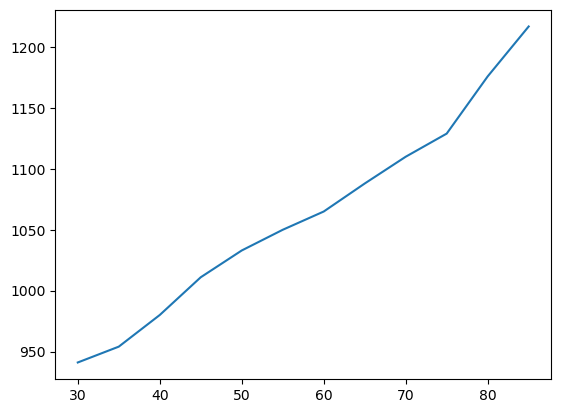

PERSON


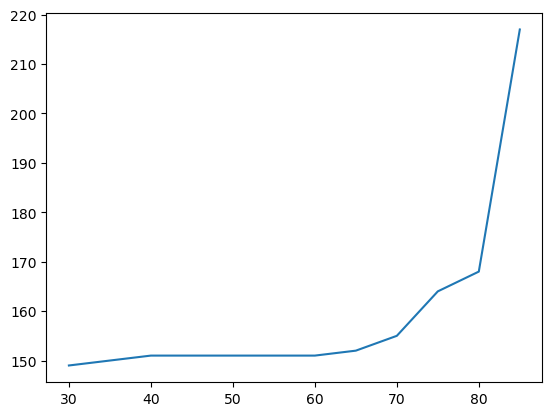

GPE


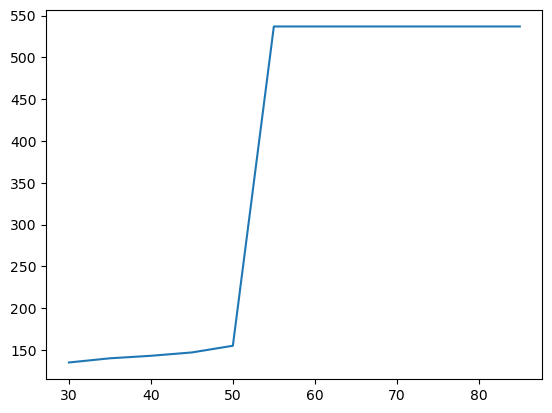

In [35]:
# Determine what cutoff to use
for ner_type in ner_types:
    number_of_clusters = dedupe_tracker[ner_type]["number_of_clusters"]
    _ = plt.plot(pd.Series(number_of_clusters))
    print(ner_type)
    plt.show()

In [36]:
for ner_type in ner_types:
    if ner_type == "ORG":
        partition = 0.75
    elif ner_type == "PERSON":
        partition = 0.80
    elif ner_type == "GPE":
        partition = 0.5
    else:
        ner_type = 0.5
    print(f"Clustering {ner_type}...")
    deduper = dedupe_tracker[ner_type][deduper_col]
    data_d = dedupe_tracker[ner_type]["data_d"]

    clustered_dupes = deduper.partition(data_d, partition)
    dedupe_tracker[ner_type]["clustered_dupes"] = clustered_dupes

Clustering ORG...
Clustering PERSON...
Clustering GPE...


In [37]:
cluster_membership = {}
ner_result_list = []
for ner_type in ner_types:
    output_file = data_path / f"ner_cluster_{ner_type}.csv"
    dedupe_tracker[ner_type]["cluster_membership"] = {}
    cluster_membership = dedupe_tracker[ner_type]["cluster_membership"]
    clustered_dupes = dedupe_tracker[ner_type]["clustered_dupes"]

    # For every cluster result, update the record in the 'df_ner' dataframe
    for cluster_id, (records, scores) in enumerate(clustered_dupes):
        for record_id, score in zip(records, scores):
            cluster_membership[record_id] = {
                "Cluster ID": cluster_id,
                "confidence_score": score,
            }
            dedupe_tracker[ner_type]["df_ner"].loc[record_id, "cluster_id"] = cluster_id
            dedupe_tracker[ner_type]["df_ner"].loc[
                record_id, "confidence_score"
            ] = score
    dedupe_tracker[ner_type]["df_ner"]["type"] = ner_type
    ner_result_list.append(dedupe_tracker[ner_type]["df_ner"])
ner_results = pd.concat(ner_result_list)
ner_results

,alert_id,label,cluster_id,confidence_score,type
0,AA22-321A,stopransomwaregov,0.0,0.951633,ORG
1,AA22-321A,the federal bureau investigation,1.0,0.951633,ORG
2,AA22-321A,fbi,2.0,0.878399,ORG
3,AA22-321A,the cybersecurity infrastructure security agency,3.0,0.945845,ORG
4,AA22-321A,cisa,4.0,0.898973,ORG
...,...,...,...,...,...
532,TA14-212A,us,18.0,0.530750,GPE
533,TA14-150A,united states,2.0,0.369386,GPE
534,TA14-150A,us,18.0,0.530750,GPE
535,TA13-169A,javadoc,154.0,1.000000,GPE


# alert to ner edge

In [38]:
best_labels_data = []
for ner_type in ner_types:
    type_results = ner_results[ner_results["type"] == ner_type]
    label_counts_by_cluster = (
        type_results.groupby(["cluster_id"]).label.value_counts().rename("freq")
    )

    # Find the most common label for each cluster and replace the others
    reference_labels = type_results.iloc[
        label_counts_by_cluster.reset_index().groupby(["cluster_id"]).freq.idxmax()
    ][["label", "cluster_id"]].rename(columns={"label": "best_label"})

    best_labels_data.append(type_results.merge(reference_labels, on="cluster_id"))
best_labels_data = pd.concat(best_labels_data)
best_ner_labels = best_labels_data[["alert_id", "best_label", "type"]].drop_duplicates()
best_ner_labels

,alert_id,best_label,type
0,AA22-321A,stopransomwaregov,ORG
14,AA22-294A,stopransomwaregov,ORG
28,AA22-257A,stopransomwaregov,ORG
42,AA22-249A,stopransomwaregov,ORG
56,AA22-223A,stopransomwaregov,ORG
...,...,...,...
8109,AA22-054A,the republic korea,GPE
8110,AA22-054A,cisco talos,GPE
8111,AA22-011A,cisagov,GPE
8112,AA21-287A,new jerseybased,GPE


In [39]:
alert_ner_label_weights = (
    best_ner_labels.groupby(by=["alert_id", "best_label"])
    .size()
    .rename("weight")
    .reset_index()
)

# Save the edge data for NER labels
alert_ner_label_weights.to_csv(data_path / "alert_ner_label_weights.csv", index=False)
alert_ner_label_weights.to_feather(data_path / "alert_ner_label_weights.feather")
alert_ner_label_weights

,alert_id,best_label,weight
0,AA18-284A,acsc,1
1,AA18-284A,acscs,1
2,AA18-284A,australia,1
3,AA18-284A,australia canada,1
4,AA18-284A,australian cyber security centre,1
...,...,...,...
3778,TA18-331A,fbi,1
3779,TA18-331A,fbis,1
3780,TA18-331A,the federal bureau investigation,1
3781,TA18-331A,us,1


In [40]:
notebook_end_time = datetime.now()
print(f"Notebook took {notebook_end_time - notebook_start_time} time to complete")

Notebook took 0:01:42.845293 time to complete
